## Study bearish engulfing on weekly timeframe for NIFTY

In [18]:
import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

import datetime

import niftyutils
from niftyutils import load_nifty_data

import matplotlib.pyplot as plt
import mplfinance as fplt

In [2]:
start_date = datetime.datetime(2005,8,1)
end_date = datetime.datetime(2020,8,29)
nifty_data = load_nifty_data(start_date,end_date)

In [3]:
weekly_nifty_data = nifty_data.resample('W').agg(niftyutils.OHLC_CONVERSION_DICT)
weekly_nifty_data.index = weekly_nifty_data.index - to_offset('6D')
weekly_nifty_data.tail(3)

,Open,High,Low,Close,Volume
Date,,,,,
2020-08-10,11270.25,11373.60,11111.45,11178.4,2.895408e+09
2020-08-17,11248.90,11460.35,11144.50,11371.6,3.299731e+09
2020-08-24,11412.00,11686.05,11410.65,11647.6,3.441270e+09


In [4]:
weekly_nifty_data['Pct_Chg'] = (weekly_nifty_data['Close']/weekly_nifty_data['Close'].shift(1) - 1)*100
weekly_nifty_data = weekly_nifty_data.dropna()
weekly_nifty_data.tail(3)

,Open,High,Low,Close,Volume,Pct_Chg
Date,,,,,,
2020-08-10,11270.25,11373.60,11111.45,11178.4,2.895408e+09,-0.317905
2020-08-17,11248.90,11460.35,11144.50,11371.6,3.299731e+09,1.728333
2020-08-24,11412.00,11686.05,11410.65,11647.6,3.441270e+09,2.427099


In [5]:
def find_weak_bearish_engulfing(ohlc_data):
    engulfing_occurence_list = []
    
    for (indx1,row1),(indx2,row2) in zip(ohlc_data[:-1].iterrows(), ohlc_data[1:].iterrows()):
        
        first_pct_change = row1['Pct_Chg']
        second_pct_change = row2['Pct_Chg']
    
        first_open = row1['Open']
        first_close = row1['Close']
        second_open = row2['Open']
        second_close = row2['Close']
        
        if first_pct_change > 0 and second_pct_change < 0 and second_close < second_open:

            first_price_range = np.array([first_open,first_close])
            if second_open > second_close :
                max_boundary = second_open
                min_boundary = second_close
            else:
                max_boundary = second_close
                min_boundary = second_open

            if np.all((first_price_range > min_boundary) & (first_price_range < max_boundary)):
                engulfing_occurence_list.append((indx1,indx2))
        
    return engulfing_occurence_list

In [6]:
find_weak_bearish_engulfing(weekly_nifty_data)[:3]

[(Timestamp('2006-04-03 00:00:00'), Timestamp('2006-04-10 00:00:00')),
 (Timestamp('2006-07-10 00:00:00'), Timestamp('2006-07-17 00:00:00')),
 (Timestamp('2006-11-27 00:00:00'), Timestamp('2006-12-04 00:00:00'))]

In [7]:
def find_full_bearish_engulfing(ohlc_data):
    engulfing_occurence_list = []
    
    for (indx1,row1),(indx2,row2) in zip(ohlc_data[:-1].iterrows(), ohlc_data[1:].iterrows()):
        
        first_pct_change = row1['Pct_Chg']
        second_pct_change = row2['Pct_Chg']
    
        first_high = row1['High']
        first_low = row1['Low']
        second_open = row2['Open']
        second_close = row2['Close']
        
        if first_pct_change > 0 and second_pct_change < 0 and second_close < second_open:

            first_price_range = np.array([first_high,first_low])
            max_boundary = second_open
            min_boundary = second_close
            
            if np.all((first_price_range > min_boundary) & (first_price_range < max_boundary)):
                engulfing_occurence_list.append((indx1,indx2))
        
    return engulfing_occurence_list

In [8]:
full_bearish_engilfing_list = find_full_bearish_engulfing(weekly_nifty_data)
full_bearish_engilfing_list

[(Timestamp('2010-12-27 00:00:00'), Timestamp('2011-01-03 00:00:00')),
 (Timestamp('2013-12-23 00:00:00'), Timestamp('2013-12-30 00:00:00')),
 (Timestamp('2014-06-30 00:00:00'), Timestamp('2014-07-07 00:00:00')),
 (Timestamp('2015-10-19 00:00:00'), Timestamp('2015-10-26 00:00:00')),
 (Timestamp('2017-09-11 00:00:00'), Timestamp('2017-09-18 00:00:00')),
 (Timestamp('2018-05-07 00:00:00'), Timestamp('2018-05-14 00:00:00')),
 (Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-20 00:00:00'))]

In [10]:
event_dates = []
for start_date,end_date in full_bearish_engilfing_list:
    event_dates.append(end_date) 

In [11]:
event_indices = []
event_annotate_text = []
for event_date in event_dates:
    event_indices.append(weekly_nifty_data.index.get_loc(event_date))
    event_annotate_text.append(event_date.strftime('%-d %b, %Y'))

### Visualize all events on full timeframe of NIFTY
This helps in developing understanding how frequent is the pattern and some broad level context - like is this pattern coincides with larger turning points.

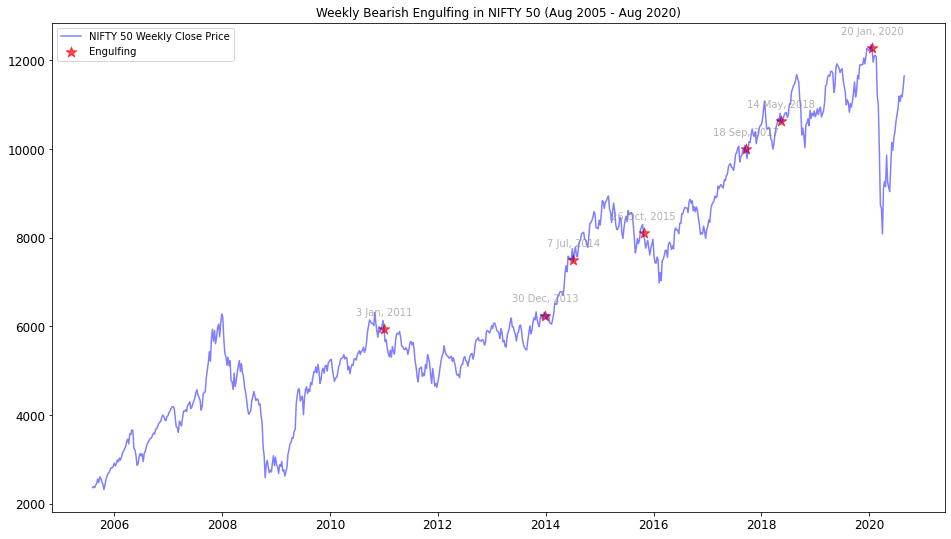

In [13]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot()

y = weekly_nifty_data['Close']
ax.plot(y, color = "blue", alpha = .5, label = "NIFTY 50 Weekly Close Price")

annotate_index_mask = [10,20,30]
ax.scatter(x = y[event_indices].index, y = y[event_indices].values+30, 
           marker = '*', s = 120, color = "red", alpha = .7, label = "Engulfing")

for event_index, annotation_text in zip(event_indices, event_annotate_text):
    ax.text(y.index[event_index], y[event_index] + 300, 
            s = annotation_text, fontsize = 10, horizontalalignment = 'center', verticalalignment = 'bottom', 
            alpha = 0.6, color = 'gray')
    
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

ax.set_title("Weekly Bearish Engulfing in NIFTY 50 (Aug 2005 - Aug 2020)", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10);

### Visualize actual engulfing event by occurence index
This helps in understanding event context and picking up important charcteristics of event

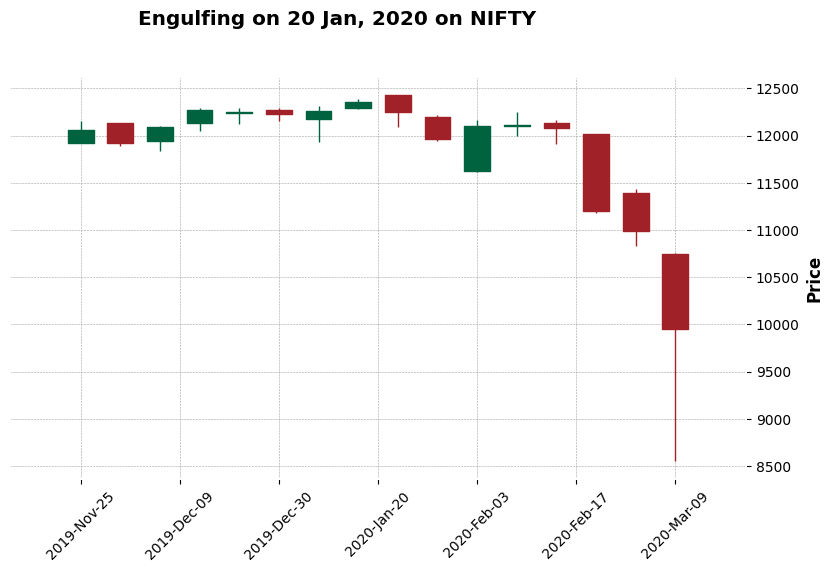

In [45]:
n_candles_before = 7
n_candles_after = 7

event_id = 6
engulfing_ix = event_indices[event_id]
event_data = weekly_nifty_data[engulfing_ix - 8 : engulfing_ix + 8].copy()
event_title = 'Engulfing on {} on NIFTY'.format(weekly_nifty_data.index[engulfing_ix].strftime('%-d %b, %Y'))
fplt.plot(event_data, type='candle',title=event_title,  
          ylabel='Price', style = 'charles', figratio=(16,9))

### Key characteristics about context and engulfing pattern

Context(Prior Action)
1. What is the trend -> Find a fittng line through context.
2. How far the price action is from EMA 10 
3. Average percent change
4. No. of red candles and No. of green candles.
5. Average gain in red and green candles
6. Range of candles
7. How many green candles in last four candles?

Engulfing
1. How big is the engulfing - ratio of engulfing candle to engulfed
2. Has engulfing created 8 week high?
3. Tail size to body ratio in engulfing
4. percentage down on engulfing day
5. percentage high on engulfing day

In [155]:
full_bearish_engilfing_list

[(Timestamp('2010-12-27 00:00:00'), Timestamp('2011-01-03 00:00:00')),
 (Timestamp('2013-12-23 00:00:00'), Timestamp('2013-12-30 00:00:00')),
 (Timestamp('2014-06-30 00:00:00'), Timestamp('2014-07-07 00:00:00')),
 (Timestamp('2015-10-19 00:00:00'), Timestamp('2015-10-26 00:00:00')),
 (Timestamp('2017-09-11 00:00:00'), Timestamp('2017-09-18 00:00:00')),
 (Timestamp('2018-05-07 00:00:00'), Timestamp('2018-05-14 00:00:00')),
 (Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-20 00:00:00'))]

In [48]:
def calculate_percent_gain(N_data):
    first_open = N_data.iloc[0]['Open']
    last_close = N_data.iloc[-1]['Close']
    percent = ((last_close - first_open)/first_open)*100
    return percent

In [49]:
key_stats_days = [1,2,3,5]
after_engulfing_list = []

for engulfing_ix in event_indices:
    key_days_gain_stats = []
    for days in key_stats_days:
        after_engulfing_data = weekly_nifty_data[engulfing_ix + 1 : engulfing_ix + 1 + days]
        pct_change = calculate_percent_gain(after_engulfing_data)
        key_days_gain_stats.append(pct_change)
    
    after_engulfing_list.append(key_days_gain_stats)

In [50]:
after_engulfing_stats = pd.DataFrame(after_engulfing_list, columns=['after_{}_weeks'.format(i) for i in key_stats_days])
after_engulfing_stats

,after_1_weeks,after_2_weeks,after_3_weeks,after_5_weeks
0,-4.181282,-3.470422,-6.594310,-10.019826
1,-0.794104,0.655859,0.737841,-2.534220
2,2.609452,4.303789,1.788727,4.320525
3,-1.244638,-3.629005,-2.458238,-3.385043
4,-1.721870,0.196785,2.081806,3.644040
5,-0.108791,0.748820,1.421817,1.932333
6,-1.926687,-0.809619,-0.685819,-8.160546


In [51]:
key_stats_days = [1,2,3,5]
before_engulfing_list = []

for engulfing_ix in event_indices:
    key_days_gain_stats = []
    for days in reversed(key_stats_days):
        before_engulfing_data = weekly_nifty_data[engulfing_ix - 1 - days: engulfing_ix - 1]
        pct_change = calculate_percent_gain(before_engulfing_data)
        key_days_gain_stats.append(pct_change)
        
    before_engulfing_list.append(key_days_gain_stats)

In [52]:
before_engulfing_stats = pd.DataFrame(before_engulfing_list, columns=['before_{}_weeks'.format(i) for i in reversed(key_stats_days)])
before_engulfing_stats

,before_5_weeks,before_3_weeks,before_2_weeks,before_1_weeks
0,1.531862,-0.365450,2.192039,1.429933
1,2.670572,1.670677,-2.194076,1.716829
2,1.077570,-1.480651,-0.345066,-0.069204
3,5.467220,4.375507,2.911269,0.080787
4,-1.389606,0.715209,0.279091,-0.494283
5,4.596297,2.115250,0.240258,-0.817318
6,2.661005,0.174493,-0.147455,0.708264


In [53]:
after_engulfing_stats['after_1_weeks'].mean()

-1.0525600187747044

In [54]:
after_engulfing_stats['after_2_weeks'].mean()

-0.28625597529992136

In [55]:
after_engulfing_stats['after_3_weeks'].mean()

-0.5297393386301547

In [56]:
after_engulfing_stats['after_5_weeks'].mean()

-2.028962537008975